In [2]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *

In [3]:
tid = 179305185

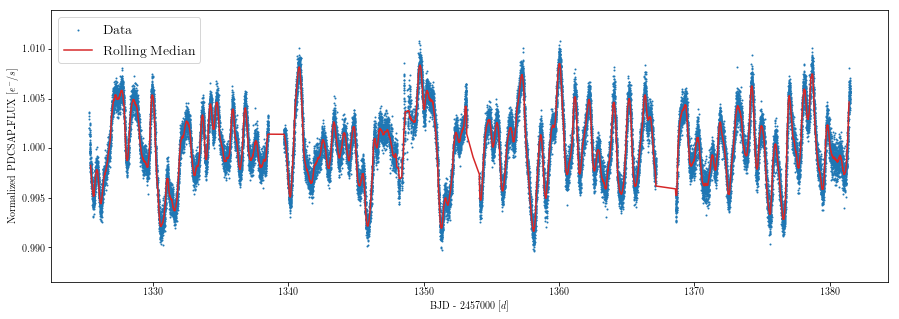

In [4]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
plt.figure(figsize=(15,5))
plt.scatter(lc['Time'],lc['Flux'],s=1,label='Data')
plt.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C3',label='Rolling Median')
plt.gca().set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

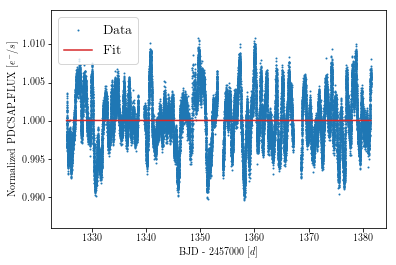

In [6]:
lc, p = polynorm(lc, deg=0)
vals = np.polyval(p, lc['Time'])
plt.scatter(lc['Time'],lc['Flux'],s=1,label='Data')
plt.plot(lc['Time'],vals,c='C3',label='Fit')
plt.gca().set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

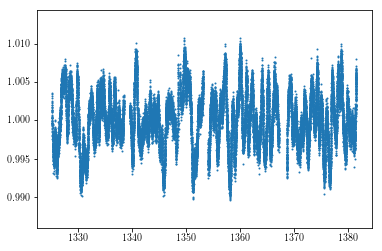

In [7]:
plt.scatter(lc['Time'],lc['NormFlux'],s=1)

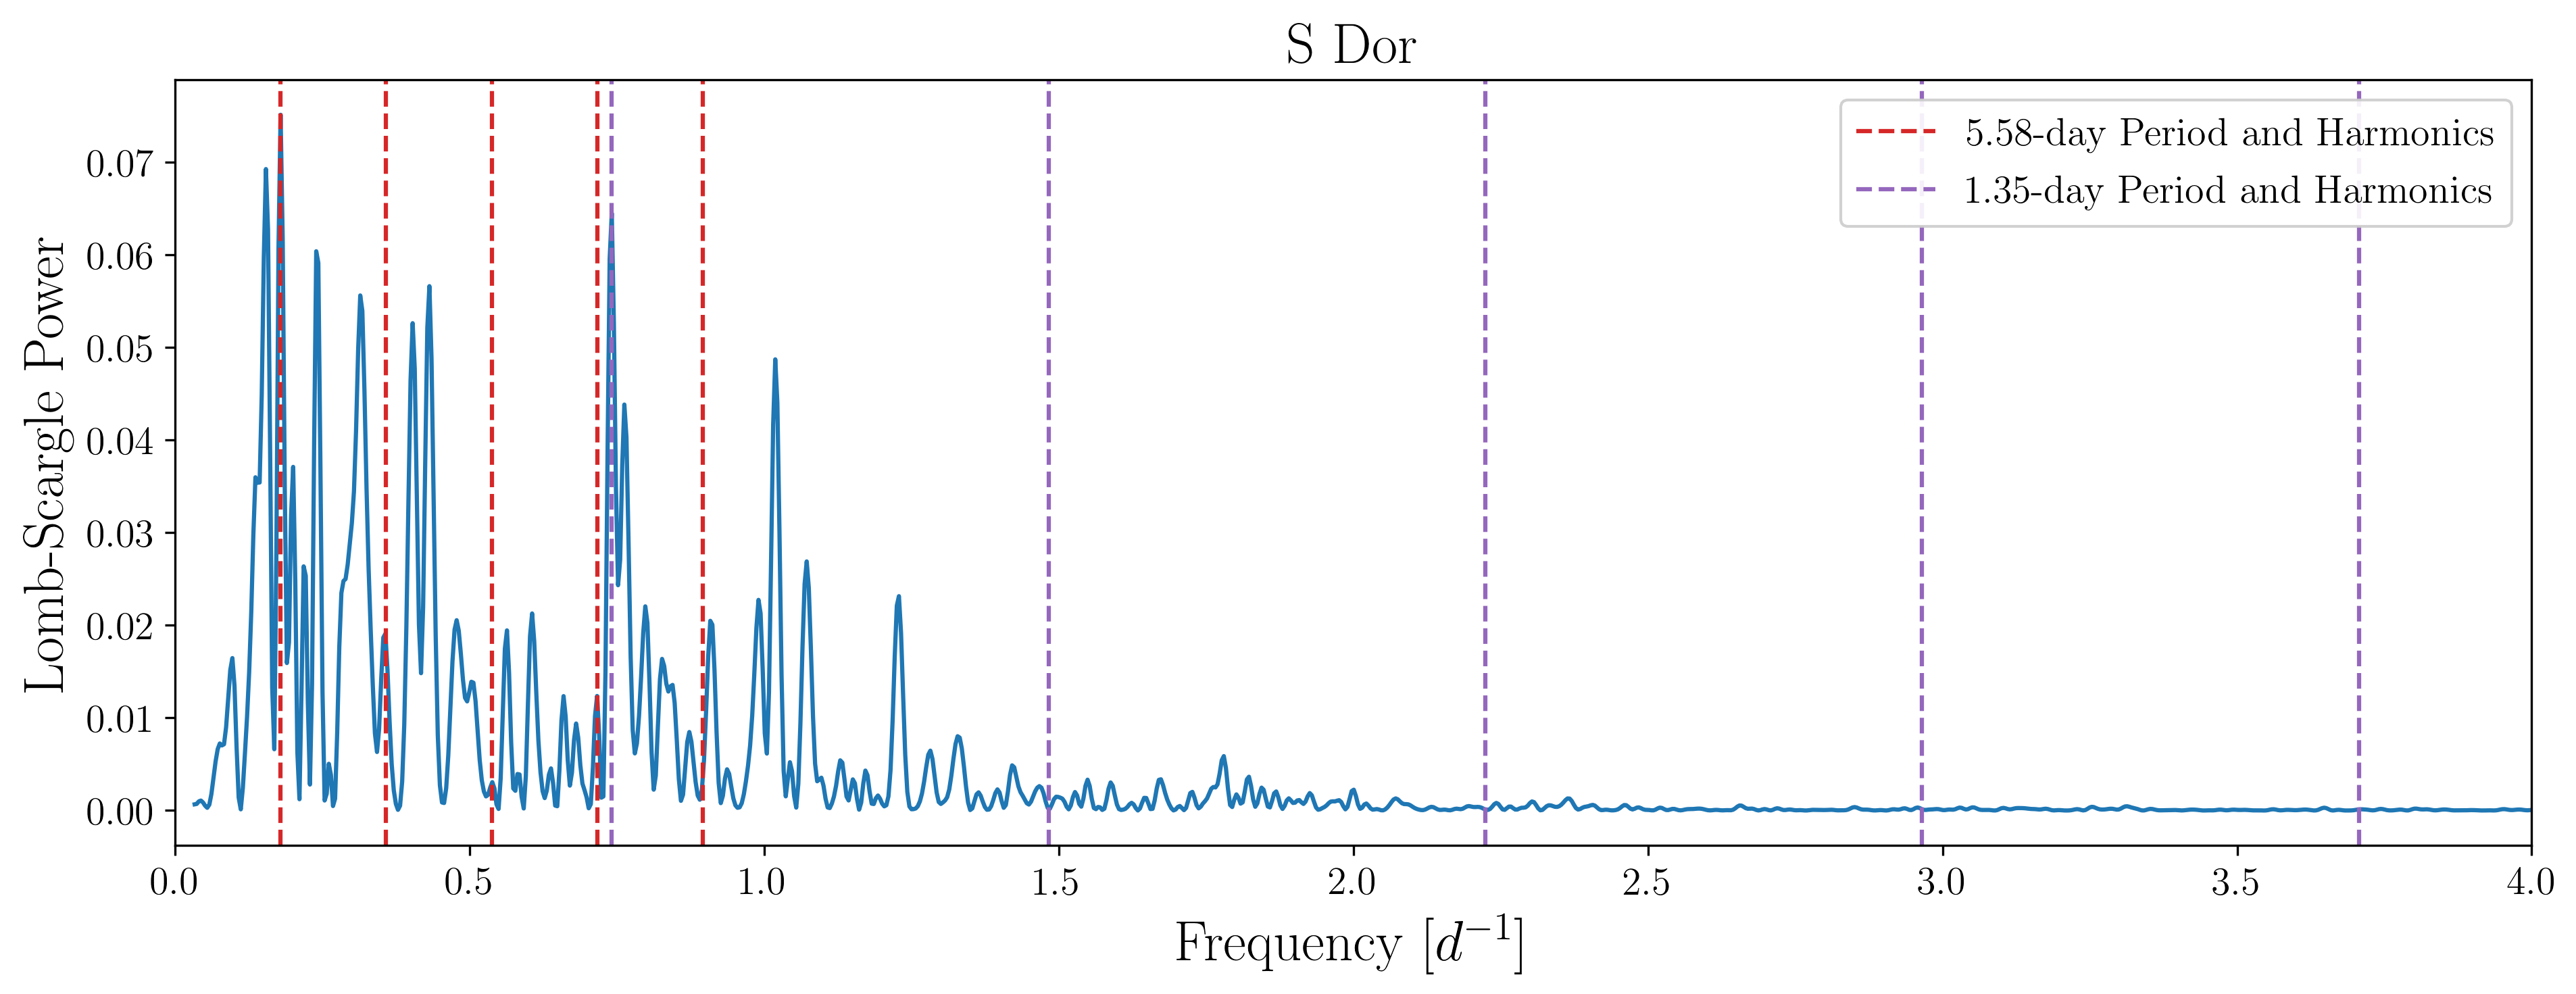

In [14]:
ls = LombScargle(lc['Time'], lc['Flux'])
pseudo_NF = 0.5 / (np.mean(np.diff(lc['Time'])))
f, p = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)

fs, ps = peak_finder(f, p, 10, width=10)

dom = fs[np.argmax(ps)]
dp = 1.0/dom

sec = fs[1]
sp = 1.0/sec

FAL = ls.false_alarm_level(0.01)

fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(f,p)
for i in np.arange(1,6):
    if i == 1:
        plt.axvline(x=(i*dom), ls='--', c='C3', label='{0:.2f}-day Period and Harmonics'.format(dp))
    else: 
        plt.axvline(x=(i*dom), ls='--', c='C3')

for i in np.arange(1,6):
    if i == 1:
        plt.axvline(x=(i*sec), ls='--', c='C4', label='{0:.2f}-day Period and Harmonics'.format(sp))
    else: 
        plt.axvline(x=(i*sec), ls='--', c='C4')        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})
ax = plt.gca()
ax.set(xlabel='Frequency [$d^{-1}$]', ylabel='Lomb-Scargle Power',xlim=(0,4));
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
ax.set_title('S Dor',fontsize=20) 
plt.savefig('../plots/SDor_periodogram.pdf')

In [13]:
dom, sec

(0.1791941727917088, 0.741292041923985)

In [8]:
# Now let's do some of the GP stuff on this with twin SHOs
gp = dSHO_maxlikelihood(lc)

Initial log likelihood: 204889.14054679289
Final log likelihood: 206684.06046729133
Maximum Likelihood Soln: OrderedDict([('kernel:terms[0]:log_S0', -12.892709770490093), ('kernel:terms[0]:log_omega0', 1.0780105408788752), ('kernel:terms[1]:log_S0', -14.29854817400825), ('kernel:terms[1]:log_Q', 0.4751960301575188), ('kernel:terms[1]:log_omega0', 1.8804870972648935), ('kernel:terms[2]:log_sigma', -7.966132138478449)])


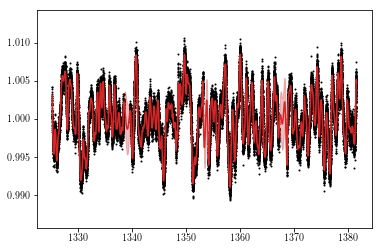

In [9]:
x = np.linspace(np.min(lc['Time']), np.max(lc['Time']), 5000)
pred_mean, pred_var = gp.predict(lc['NormFlux'], x, return_var=True)
pred_std = np.sqrt(pred_var)

plt.scatter(lc['Time'], lc['NormFlux'], s=1, c='k')
plt.plot(x, pred_mean, color='C3')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='C3', alpha=0.3,
                 edgecolor="none")

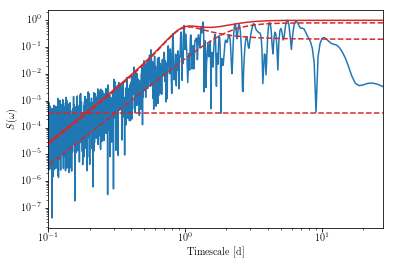

In [11]:
omega = np.exp(np.linspace(np.log(2.0*np.pi/28.0), np.log(2.0*np.pi/0.1), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(1.0/f,p/np.max(p),c='C0')
plt.plot(2.0*np.pi/omega, psd/np.max(psd), color='C3')
for k in gp.kernel.terms:
    plt.plot(2.0*np.pi/omega, k.get_psd(omega)/np.max(psd), "--", color='C3')
plt.axhline(y=np.exp(gp.kernel.terms[2].get_parameter_dict()['log_sigma']),ls='--', color='C3')

plt.yscale("log")
plt.xscale("log")
plt.xlim(2.0*np.pi/omega[-1], 2.0*np.pi/omega[0])
plt.xlabel("Timescale [d]")
plt.ylabel("$S(\omega)$");